# NanoSafety data exploration



In [1]:
import yaml
from pynanomapper import aa
from pynanomapper import units
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import requests
from importlib import reload 
from pynanomapper import client_solr
from pynanomapper import client_ambit
from pynanomapper import annotation
import pandas as pd
import numpy as np
import json
import pandas as pd
import importlib
import qgrid
import warnings
import seaborn as sns

import matplotlib.pyplot as plt
import io
import qgrid
from measurement.utils import guess
from measurement.measures import Distance, Temperature, Volume, Area, Frequency, Mass, Time
#init_notebook_mode(connected=True)
warnings.simplefilter("ignore")

In [3]:
print('Select enanoMapper aggregated search service:')
style = {'description_width': 'initial'}
config,config_servers, config_security, auth_object, msg = aa.parseOpenAPI3()    
service_widget = widgets.Dropdown(
    options=config_servers['url'],
    description='Service:',
    disabled=False,
    style=style
)
if config_security is None:
    service = interactive(aa.search_service_open,url=service_widget)
else:
    print(msg)
    apikey_widget=widgets.Text(
            placeholder='',
            description=config_security,
            disabled=False,
            style=style
    )    
    service = interactive(aa.search_service_protected,url=service_widget,apikey=apikey_widget)    

display(service)

Select enanoMapper aggregated search service:
Enter `X-Gravitee-Api-Key` you have received upon subscription to http://api.ideaconsult.net


interactive(children=(Dropdown(description='Service:', options=('https://api.ideaconsult.net/enanomapper', 'ht…

In [3]:
service_uri=service_widget.value
if auth_object!=None:
    auth_object.setKey(apikey_widget.value)
print("Sending queries to {}".format(service_uri))

f_method="E.method_s"
f_method_synonyms="E.method_synonym_ss"
f_materialtype="substanceType_s"
f_materialtypename="substanceType_name"
f_materialname="publicname_s"
f_value="Number of data points"


Sending queries to https://api.ideaconsult.net/gracious


##  Study query

In [4]:
pie_widget=widgets.Text(
        placeholder='',
        value="NRCWE-006",
        description="Query",
        disabled=False,
        style=style
)
display(pie_widget)

Text(value='NRCWE-006', description='Query', placeholder='', style=DescriptionStyle(description_width='initial…

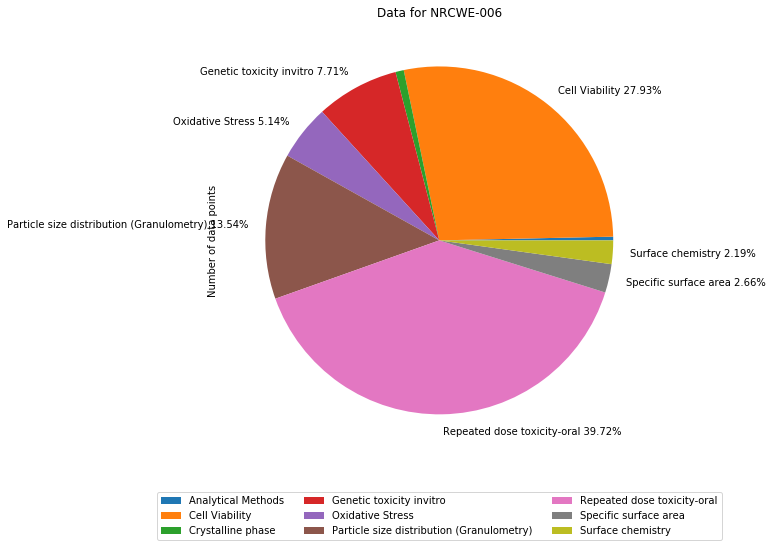

In [5]:
reload(client_solr)
reload(annotation)
facets = client_solr.Facets()

q=pie_widget.value
if q=="":
    q="*:*"
df = facets.summary(service_uri,auth_object, query=q,fields=["topcategory_s","endpointcategory_s","owner_name_s",f_method,f_method_synonyms,f_materialtype,f_materialname])    
a = annotation.DictionaryEndpointCategoryNames()
df[ 'endpoint']=df[ 'endpointcategory_s'].apply(a.annotate)

A = df.groupby(["endpoint"]).agg({f_value : sum}).reset_index()
_sum = A[f_value].sum()
_display_labels_threshold = 0.008
A["labels"] =  A[['endpoint',f_value]].apply(lambda x : '{} {:.2f}%'.format(x[0],100*x[1]/_sum) if x[1]/_sum >_display_labels_threshold else "", axis=1)

ax = A.plot.pie(y=f_value, figsize=(8,8),labels=A["labels"],  shadow=False)

ax.legend(A["endpoint"],loc='lower center',bbox_to_anchor=(0.5,-0.2),  ncol=3)
plt.title("Data for " + pie_widget.value)
 

plt.savefig('Fig3B.png'  , dpi=300, bbox_inches='tight')        
plt.savefig('Fig3B.eps',orientation="portrait",dpi=300, bbox_inches='tight')
#plt.savefig('Fig3B.tiff',dpi=300, bbox_inches='tight')
plt.savefig('Fig3B.pdf', bbox_inches='tight')
plt.savefig('Fig3B.svg', bbox_inches='tight')

In [6]:
    query_widget=widgets.Text(
        placeholder='',
        value="",
        description="Query",
        disabled=False,
        style=style
    )
    display(query_widget)

Text(value='', description='Query', placeholder='', style=DescriptionStyle(description_width='initial'))

In [7]:
reload(client_solr)
reload(annotation)
facets = client_solr.Facets()



q=query_widget.value
if q=="":
    q="*:*"
df = facets.summary(service_uri,auth_object, query=q,fields=["topcategory_s","endpointcategory_s","owner_name_s",f_method,f_method_synonyms,f_materialtype,f_materialname])    

a = annotation.DictionaryEndpointCategoryNames()
df[ 'endpoint']=df[ 'endpointcategory_s'].apply(a.annotate)

dict = annotation.DictionarySubstancetypes()
dict.verbose=False

A = df.groupby([f_materialtypename,f_materialname]).agg({f_method: "count", f_value : sum}).reset_index()
#A
B = A.groupby([f_materialtypename]).agg({f_materialname : "count", f_method: sum, f_value : sum}).reset_index()


qgrid.show_grid(df)
#qgrid.show_grid(A)
qgrid.show_grid(B)
f_nnanoforms="Number of nanoforms"
B.rename(columns={f_materialname : f_nnanoforms},inplace=True)


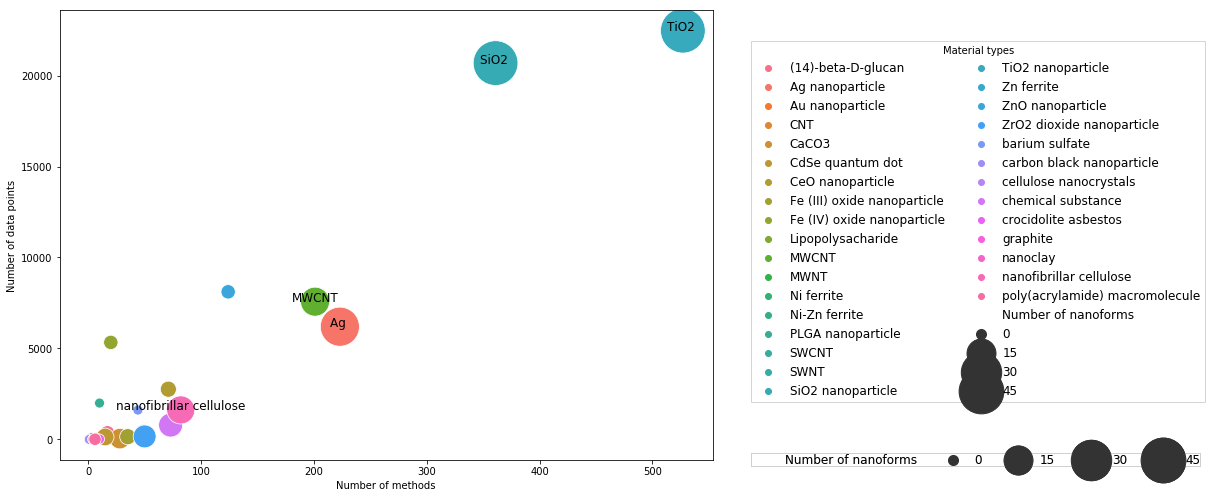

In [8]:
reload(client_solr)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
#sns.set(rc={'figure.figsize':(10,10)})
dict = annotation.DictionarySubstancetypes(verbose=False)
ax = sns.scatterplot(x=f_method, y=f_value, size=f_nnanoforms,hue=f_materialtypename,data=B, sizes=(100, 2000),legend="brief"
                     #,hue_order=dict.lookup.properties.values()
                    )

figname="Fig2"
_log = False
if _log:
    ax.set(xscale="log")
    ax.set(yscale="log")
    _threshold=3
    figname=figname+"_log"
else:
    _threshold=10
    
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.title(query_widget.value)
# Set x-axis label
plt.xlabel("log (number of methods)" if _log else "Number of methods")
plt.ylabel("log (number of data points)" if _log else "Number of data points")

for line in range(0,B.shape[0]):
     if B[f_nnanoforms][line]>_threshold:
         ax.text(B[f_method][line], B[f_value][line], 
         B.substanceType_name[line].replace("nanoparticle",""), horizontalalignment='center', 
         size='large', color='black')
        
        
h,l = ax.get_legend_handles_labels()

col_lgd = plt.legend(h[1:43], l[1:43], title='Material types',loc='center left', prop={'size': 12},bbox_to_anchor=(1.05, 0.53), fancybox=False, shadow=False, ncol=2)


#size_lgd = plt.legend(h[-5:], l[-5:], loc='center left', borderpad=0, prop={'size': 12},  bbox_to_anchor=(1.05, 0), fancybox=False, shadow=False, ncol=5)

size_lgd = plt.legend(h[-5:], l[-5:], loc='center left', borderpad=0, prop={'size': 12},  bbox_to_anchor=(1.05, 0), fancybox=False, shadow=False, ncol=5)
#ax.legend(A["endpoint"],loc='lower center',bbox_to_anchor=(0.5,-0.2),  ncol=3)

plt.gca().add_artist(col_lgd)
plt.gca().add_artist(size_lgd)

        
plt.savefig(figname + '.png'  , dpi=300, bbox_inches='tight')        
plt.savefig(figname + '.eps',orientation="landscape",dpi=300, bbox_inches='tight')
#plt.savefig(figname + '.tiff',dpi=300, bbox_inches='tight')
plt.savefig(figname + '.pdf', bbox_inches='tight')
plt.savefig(figname + '.svg', bbox_inches='tight')
plt.show()


### Visualisation of two types of data

In [9]:
query_tag="omics"
df[query_tag] =  np.where(df['endpointcategory_s']=='OMICS_SECTION',df[f_value],0)

#query_tag="Physicochemical characterisation"
#df[query_tag] =  np.where(df['topcategory_s']=='P-CHEM',df[f_value],0)

#query_tag="COMET"
#df[query_tag] =  np.where(df['E.method_s']=='COMET',df[f_value],0)


df["other"] = df[f_value] - df[query_tag]

A = df.groupby([f_materialtypename,f_materialname]).agg({query_tag: "sum","other": "sum", f_value : sum}).reset_index()
B = A.groupby([f_materialtypename]).agg({f_materialname : "count", query_tag: "sum","other": "sum", f_value : sum}).reset_index()

f_nnanoforms="Number of nanoforms"
B.rename(columns={f_materialname : f_nnanoforms},inplace=True)
qgrid.show_grid(B)       

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

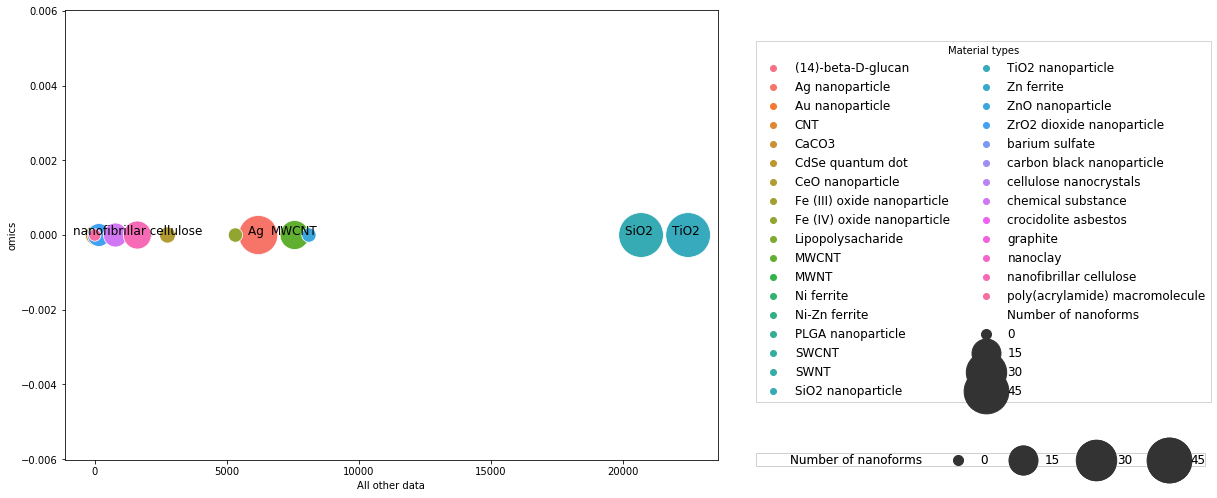

In [10]:
plt.figure()
rcParams['figure.figsize'] = 11.7,8.27
ax = sns.scatterplot(x="other", y=query_tag, size=f_nnanoforms,hue=f_materialtypename,data=B, sizes=(100, 2000) )

_log = False

if _log:
    ax.set(xscale="log")
    ax.set(yscale="log")
    _threshold=3
else:
    _threshold=12
#ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.title(query_widget.value)
# Set x-axis label
plt.xlabel("All other data")

for line in range(0,B.shape[0]):
     if B[f_nnanoforms][line]>_threshold:
         ax.text(B["other"][line]+0.01, B[query_tag][line], 
         B.substanceType_name[line].replace("nanoparticle",""), horizontalalignment='center', 
         size='large', color='black')
        
h,l = ax.get_legend_handles_labels()

col_lgd = plt.legend(h[1:43], l[1:43], title='Material types',loc='center left', prop={'size': 12},bbox_to_anchor=(1.05, 0.53), fancybox=False, shadow=False, ncol=2)

# bbox_to_anchor=(-0.05, -0.50)
#size_lgd = plt.legend(h[-5:], l[-5:], loc='lower center', borderpad=1.6, prop={'size': 20},    bbox_to_anchor=(0.5,-0.45), fancybox=True, shadow=True, ncol=5)
#size_lgd = plt.legend(h[-5:], l[-5:], loc='center left',  bbox_to_anchor=(1.05, 0,15,0), fancybox=False, shadow=False, ncol=5)
size_lgd = plt.legend(h[-5:], l[-5:], loc='center left', borderpad=0, prop={'size': 12},  bbox_to_anchor=(1.05, 0), fancybox=False, shadow=False, ncol=5)

plt.gca().add_artist(col_lgd)        
plt.gca().add_artist(size_lgd)   

plt.savefig('Fig3A.png', bbox_inches='tight')        
plt.savefig('Fig3A.eps',orientation="landscape",dpi=300,  bbox_inches='tight')
#plt.savefig('Fig3A.tiff',dpi=300,  bbox_inches='tight')
plt.savefig('Fig3A.pdf', bbox_inches='tight')
plt.savefig('Fig3A.svg', bbox_inches='tight')

## Get the study results

In [11]:

url=service_uri + "/select?"
maxrows=100000
qvalue=query_widget.value
if qvalue=="":
    qvalue="*:*"
q = {"fl": "name:name_s,material_name:publicname_s,project:owner_name_s,material_type_annotation:substanceType_s,category:topcategory_s,endpointcategory_s,protocol:guidance_s,descriptor:effectendpoint_s,descriptor_type:effectendpoint_type_s,descriptor_annotation:effectendpoint_synonym_ss,provider:reference_owner_s,citation:reference_s,citation_year:reference_year_s,text_value:textValue_s,loValue:loValue_d,upValue:upValue_d,uncertainty:err_value_d,unit:unit_s,method:E.method_s,method_annotation:E.method_synonym_ss,descriptor_annotation:effectendpoint_synonym_ss,textValue:textValue_s",
      "fq":"type_s:study","wt":"csv", "rows":maxrows,
     "q":qvalue

#     "q":"(endpointcategory_s:PC_GRANULOMETRY_SECTION) AND (owner_name_s:SANOWORK)"
#       "q":"endpointcategory_s:SPECIFIC_SURFACE_AREA_SECTION"
#       "q":"endpointcategory_s:DUSTINESS_SECTION"     
#       "q":"endpointcategory_s:CRYSTALLINE_PHASE_SECTION"          
#       "q":"endpointcategory_s:POROSITY_SECTION"          
#        "q":"endpointcategory_s:AGGLOMERATION_AGGREGATION_SECTION"          
#        "q":"endpointcategory_s:PC_DENSITY_SECTION"               
#        "q":"endpointcategory_s:TO_GENETIC_IN_VITRO_SECTION"             
#        "q":"TO_GENETIC_IN_VITRO_SECTION  AND COMET"                
#         "q" : "ENM_0000068_SECTION"
#         "q" : "NPO_1339_SECTION"
#         "q" : "TO_REPEATED_ORAL_SECTION"
#         "q" : "TO_REPEATED_INHAL_SECTION"
#         "q" : "ENM_0000037_SECTION"     
    }
r = client_solr.get(url,query=q,auth=auth_object)
df=pd.read_csv(io.StringIO(r.content.decode('utf-8')))
df.head()

try:
    a = annotation.DictionarySubstancetypes()
    df[ 'material_type']=df[ 'material_type_annotation'].apply(a.annotate)
except:
    pass
    
a = annotation.DictionaryEndpointCategoryNames()
df[ 'endpoint']=df[ 'endpointcategory_s'].apply(a.annotate)



In [12]:

qgrid_widget = qgrid.show_grid(df[['project','material_type','material_name','endpoint','method','method_annotation','descriptor','descriptor_annotation','descriptor_type','unit','loValue','upValue','uncertainty','textValue']])
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Unit conversion (if needed)

In [13]:
df_filtered = qgrid_widget.get_changed_df()
uq = df_filtered["unit"].unique()
    
def convert_units_df(to_unit=None,debug=True):
    if to_unit==None:
        df_filtered['loValue_std'] =  df_filtered['loValue']
        df_filtered['upValue_std'] =   df_filtered['upValue']
        df_filtered['uncertainty_std'] = df_filtered['uncertainty']
        df_filtered['unit_std'] = df_filtered['unit']   
        if debug:
            display(df_filtered.head(3))
    else:    
        df_filtered['loValue_std'] = df_filtered.apply(lambda x: units.convert_units(x.loValue, x.unit,  to_unit), axis=1)
        df_filtered['upValue_std'] = df_filtered.apply(lambda x: units.convert_units(x.upValue, x.unit,to_unit), axis=1)
        df_filtered['uncertainty_std'] = df_filtered.apply(lambda x: units.convert_units(x.uncertainty, x.unit, to_unit), axis=1)
        df_filtered['unit_std'] = to_unit
        
        
        if debug:
            display(df_filtered[df_filtered["unit"]!=to_unit].head(3))
    
    return to_unit


convert_units_df(None,debug=False)
try:
    interact(convert_units_df, to_unit=uq);
except Exception as err:    
    print(err)
    pass;

Invalid selection: value not found


# Boxplot

In [14]:
x_widget = widgets.Dropdown(
    options= df_filtered.select_dtypes(include=[object]),
    description='X:',
    value='material_type',
    disabled=False
)
y_widget = widgets.Dropdown(
    options= ["loValue_std","upValue_std","uncertainty_std","loValue","upValue","uncertainty"],
    description='Y:',
    value='loValue_std',
    disabled=False
)
hue_widget = widgets.Dropdown(
    options= df_filtered.select_dtypes(include=[object]),
    description='hue:',
    value='descriptor',
    disabled=False
)
col_widget = widgets.Dropdown(
    options= df_filtered.select_dtypes(include=[object]),
    description='col:',
    value='endpoint',
    disabled=False
)


In [ ]:
sns.set(style="ticks")
sns.set(rc={'figure.figsize':(20,10)})
def striplot(x,y, hue, boxplot):
    try:    
        if boxplot:
            ax = sns.boxplot(x,y, data=df_filtered, whis=np.inf)
        ax = sns.stripplot(x,y,  hue=hue, dodge=True, data=df_filtered, jitter=True)
        ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        ylabel = '{} [{}]'.format(','.join(df_filtered['descriptor'].unique()), ','.join(df_filtered['unit_std'].unique()))
        print(ylabel)
        ax.ylabel(ylabel)
        ax.xlabel(x)
    except:
        pass
interact(striplot,x= x_widget, y=y_widget, hue = hue_widget, boxplot=True);    

interactive(children=(Dropdown(description='X:', index=1, options=('project', 'material_type', 'material_name'…

## Heat map

In [ ]:
p = df_filtered.pivot_table(index=["endpoint","method","descriptor","unit_std"],columns=["material_type","material_name"],values=[y_widget.value])
p

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(p)


## Endpoints

In [ ]:
import matplotlib.pyplot as plt
binary = ["#ff0000","#00ff00"]
sns.set_palette(binary)
#red/green palette

  
def plot_heatmap(table,q, cmap=binary,save=False):    
    sns.palplot(cmap)
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    sns_plot = sns.heatmap(table, cmap=cmap)
    sns_plot.set_title(q)
    if save:
        sns_plot.get_figure().savefig(q+".png")
    return (sns_plot)

In [ ]:
def queryEndpoints(top="TOX",q="*:*"):
    try:
        df = facets.summary(service_uri,auth_object,query="(topcategory_s:"+top + ") AND (" + q + ")",fq="type_s:study",statistics="Number of data points", fields=["topcategory_s","endpointcategory_s","effectendpoint_s","substanceType_s","publicname_s"])        
        df.rename(columns={"owner_name_s" : "Project","topcategory_s":"Study type","substanceType_name": "NM type","endpointcategory_name":"endpoint"},inplace=True)
        table = pd.pivot_table(df, values="Number of data points", index=['NM type'], columns=['endpoint' ], aggfunc='any').fillna(False)
        plot_heatmap(table,q)
    except:
        pass

interact(queryEndpoints,top=["TOX","P-CHEM","ECOTOX","ENV FATE"],q="*:*")

## Composition

In [ ]:
url=service_uri + "/select?"

maxrows=10000
q = {"fl" : "s_uuid_hs,component_s,ChemicalName_s,CASRN_s,SMILES_s",
      "fq":"type_s:composition","wt":"csv", "rows":maxrows,
     "q":"*:*"
     
    }
r = client_solr.get(url,query=q,auth=auth_object)
df=pd.read_csv(io.StringIO(r.content.decode('utf-8')))
qgrid.show_grid(df)

In [ ]:
.

In [ ]:
reload(annotation)
dict = annotation.DictionarySubstancetypes(verbose=True)

dict.annotate("NPO_1486")